# Tweets about Covid-19 vaccines

In [1]:
# Import packages
import nltk
from pprint import pprint
import yaml
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import neattext as ntx
from wordcloud import WordCloud

## Part 1: EDA on post_covidTweets

In [2]:
data = pd.read_csv('post_covidTweets.csv')
data.head()

datetime             tweet_id  \
0  2023-02-27 23:27:46+00:00  1630349000141426688   
1  2023-02-27 22:25:54+00:00  1630333430125973505   
2  2023-02-27 22:12:20+00:00  1630330016902029313   
3  2023-02-27 20:36:33+00:00  1630305909154131968   
4  2023-02-27 20:29:33+00:00  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...  
1             ['AndyVermautLovesReutersPressAgency']  
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...  
3                                                NaN  
4                                                NaN

In [3]:
data.shape

(20560, 12)

In [4]:
data.isnull().sum()

datetime              0
tweet_id              0
text                  0
username              0
url                   0
user_location      2466
like_count            0
retweet_count         0
follower_count        0
reply_count           0
verified              0
hashtags          17890
dtype: int64

### Simple visualisation (E.g Visualizing Tweet count vs Location)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Virginia Beach, Virginia'),
  Text(1, 0, 'Diksmuide, België'),
  Text(2, 0, 'Around the world'),
  Text(3, 0, 'New York, NY'),
  Text(4, 0, 'Tanzania'),
  Text(5, 0, 'New York City'),
  Text(6, 0, 'Texas'),
  Text(7, 0, 'Philadelphia PA, USA'),
  Text(8, 0, 'Washington, DC'),
  Text(9, 0, 'Toronto'),
  Text(10, 0, 'Englewood Cliffs, NJ'),
  Text(11, 0, 'London, England'),
  Text(12, 0, 'El Segundo, CA'),
  Text(13, 0, 'Austin, Texas'),
  Text(14, 0, 'Saskatoon'),
  Text(15, 0, 'San Francisco Bay Area'),
  Text(16, 0, 'USA'),
  Text(17, 0, 'New Zealand'),
  Text(18, 0, 'Washington DC | Virginia'),
  Text(19, 0, 'Dublin City, Ireland')])

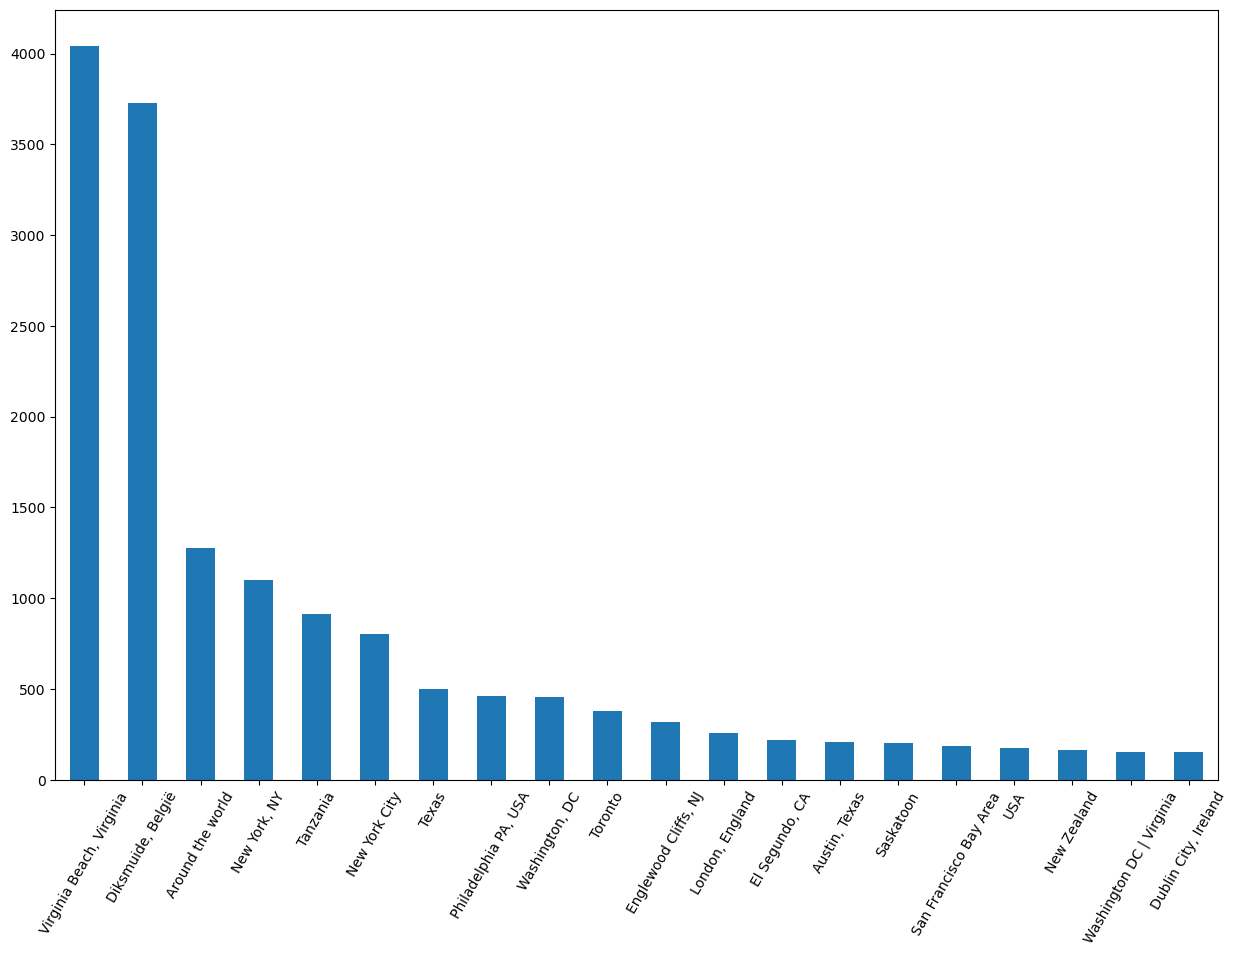

In [5]:
plt.figure(figsize=(15,10))
data['user_location'].value_counts().nlargest(20).plot(kind='bar')
plt.xticks(rotation=60)

### Word cloud in general (What do ppl talk about - Most frequent words or top keywords) 

(-0.5, 999.5, 499.5, -0.5)

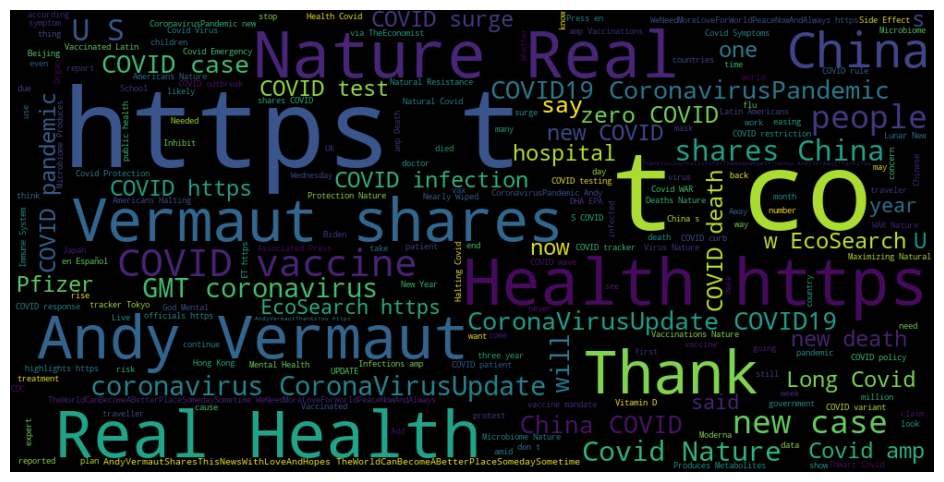

In [6]:
words = ' '.join([word for word in data['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

### Check for duplicate tweets based on the tweet content

In [7]:
duplicate_tweets = data[data.duplicated(['text'])]
print('Number of duplicate tweets:', len(duplicate_tweets))

Number of duplicate tweets: 3540


### Drop duplicate tweets

In [8]:
data = data.drop_duplicates('text')
data.shape

(17020, 12)

### <font color=#FF0000>**Sentiment Analysis (using Textblob)**</font> <br>
**Polarity:** 1 means positive statement, -1 means a negative statement and 0 means neutral.
<br>
**Subjectivity:** Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is a float which lies in the range of [0,1].

### Clean the data using neattext library

In [9]:
data['clean_data'] = data['text'].apply(ntx.remove_hashtags)
data['clean_data'] = data['clean_data'].apply(ntx.remove_urls)
data['clean_data'] = data['clean_data'].apply(ntx.remove_userhandles)
data['clean_data'] = data['clean_data'].apply(ntx.remove_multiple_spaces)
data['clean_data'] = data['clean_data'].apply(ntx.remove_special_characters)

In [10]:
data['clean_data']

0        Andy Vermaut sharesDOE finds COVID19 pandemic ...
1        No consensus on how COVID started says White H...
2        Andy Vermaut sharesABC News Rachel Scott press...
3        Andy Vermaut sharesModerna to Make Milestone P...
4        Andy Vermaut sharesPfizer in Talks to Buy Canc...
                               ...                        
20555     Under HEROES Act gives administrationauthorit...
20556    Fragment crystallizable receptoreffector funct...
20557    Plasma from vaccinated and COVID19 convalescen...
20558     Did you see a definition that stated complete...
20559      No vaccine kills bacteria or virusesor anything
Name: clean_data, Length: 17020, dtype: object

In [11]:
data.shape

(17020, 13)

### Using stopwords to remove words that are generally considered to be of little value 

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [13]:
stop_words = stopwords.words('english')   
len(stop_words)

179

In [14]:
def stopWords(tweet):
    clean_tweet = tweet
    clean_tweet = " ".join(word for word in clean_tweet.split() if word not in stop_words)
    return clean_tweet

In [15]:
data['clean_data'] = data['clean_data'].apply(lambda x: stopWords(x))

In [16]:
data.head()

datetime             tweet_id  \
0  2023-02-27 23:27:46+00:00  1630349000141426688   
1  2023-02-27 22:25:54+00:00  1630333430125973505   
2  2023-02-27 22:12:20+00:00  1630330016902029313   
3  2023-02-27 20:36:33+00:00  1630305909154131968   
4  2023-02-27 20:29:33+00:00  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  \
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
1             ['AndyVermautLovesReutersPressAgency']   
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
3                                                NaN   
4                                                NaN   

                                          clean_data  
0  Andy Vermaut sharesDOE finds COVID19 pandemic ...  
1        No consensus COVID started says White House  
2  Andy Vermaut sharesABC News Rachel Scott press...  
3  Andy Vermaut sharesModerna Make Milestone Paym...  
4  Andy Vermaut sharesPfizer Talks Buy Cancer Dru...

### Assigning Polarity and Subjectivity to the Tweets using Textblob

In [17]:
from textblob import TextBlob

# Function to assign polarity and subjectivity to the tweets
def blob_fun(text):
    senti = TextBlob(text)
    senti_polarity = senti.sentiment.polarity
    senti_subjectivity = senti.sentiment.subjectivity
    
    if senti_polarity > 0:
        res = 'Positive'
    elif senti_polarity < 0:
        res = 'Negative'
    elif senti_polarity == 0:
        res ="Neutral"
        
    result = {'polarity':senti_polarity,'subjectivity':senti_subjectivity,'sentiment':res}
    
    return result

In [18]:
data['results'] = data['clean_data'].apply(lambda x: blob_fun(x))

In [19]:
data.head()

datetime             tweet_id  \
0  2023-02-27 23:27:46+00:00  1630349000141426688   
1  2023-02-27 22:25:54+00:00  1630333430125973505   
2  2023-02-27 22:12:20+00:00  1630330016902029313   
3  2023-02-27 20:36:33+00:00  1630305909154131968   
4  2023-02-27 20:29:33+00:00  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  \
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
1             ['AndyVermautLovesReutersPressAgency']   
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
3                                                NaN   
4                                                NaN   

                                          clean_data  \
0  Andy Vermaut sharesDOE finds COVID19 pandemic ...   
1        No consensus COVID started says White House   
2  Andy Vermaut sharesABC News Rachel Scott press...   
3  Andy Vermaut sharesModerna Make Milestone Paym...   
4  Andy Vermaut sharesPfizer Talks Buy Cancer Dru...   

                                             results  
0  {'polarity': 0.0, 'subjectivity': 1.0, 'sentim...  
1  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  
2  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  
3  {'polarity': 0.028571428571428567, 'subjectivi...  
4  {'polarity': 0.16666666666666666, 'subjectivit...

In [20]:
data.shape

(17020, 14)

In [21]:
data = data.join(pd.json_normalize(data = data['results']))

In [22]:
data.head()

datetime             tweet_id  \
0  2023-02-27 23:27:46+00:00  1630349000141426688   
1  2023-02-27 22:25:54+00:00  1630333430125973505   
2  2023-02-27 22:12:20+00:00  1630330016902029313   
3  2023-02-27 20:36:33+00:00  1630305909154131968   
4  2023-02-27 20:29:33+00:00  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  \
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
1             ['AndyVermautLovesReutersPressAgency']   
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
3                                                NaN   
4                                                NaN   

                                          clean_data  \
0  Andy Vermaut sharesDOE finds COVID19 pandemic ...   
1        No consensus COVID started says White House   
2  Andy Vermaut sharesABC News Rachel Scott press...   
3  Andy Vermaut sharesModerna Make Milestone Paym...   
4  Andy Vermaut sharesPfizer Talks Buy Cancer Dru...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 1.0, 'sentim...  0.000000      1.000000   
1  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
2  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
3  {'polarity': 0.028571428571428567, 'subjectivi...  0.028571      0.392857   
4  {'polarity': 0.16666666666666666, 'subjectivit...  0.166667      0.633333   

  sentiment  
0   Neutral  
1   Neutral  
2   Neutral  
3  Positive  
4  Positive

In [23]:
data.rename(columns={'sentiment': 'Textblob'}, inplace=True)

In [24]:
data.head()

datetime             tweet_id  \
0  2023-02-27 23:27:46+00:00  1630349000141426688   
1  2023-02-27 22:25:54+00:00  1630333430125973505   
2  2023-02-27 22:12:20+00:00  1630330016902029313   
3  2023-02-27 20:36:33+00:00  1630305909154131968   
4  2023-02-27 20:29:33+00:00  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  \
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
1             ['AndyVermautLovesReutersPressAgency']   
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
3                                                NaN   
4                                                NaN   

                                          clean_data  \
0  Andy Vermaut sharesDOE finds COVID19 pandemic ...   
1        No consensus COVID started says White House   
2  Andy Vermaut sharesABC News Rachel Scott press...   
3  Andy Vermaut sharesModerna Make Milestone Paym...   
4  Andy Vermaut sharesPfizer Talks Buy Cancer Dru...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 1.0, 'sentim...  0.000000      1.000000   
1  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
2  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
3  {'polarity': 0.028571428571428567, 'subjectivi...  0.028571      0.392857   
4  {'polarity': 0.16666666666666666, 'subjectivit...  0.166667      0.633333   

   Textblob  
0   Neutral  
1   Neutral  
2   Neutral  
3  Positive  
4  Positive

### Visualize Positive, Negative & Neutral sentiments (wordcloud, bar chart & sentiments of positive, negative, and neutral based on different countries.

In [25]:
# categorized tweets in seperate Series
positive_tweet =  data[data['Textblob'] == 'Positive']['clean_data']
negative_tweet =  data[data['Textblob'] == 'Negative']['clean_data']
neutral_tweet = data[data['Textblob'] == 'Neutral']['clean_data']

In [26]:
def percent(x,y):
    return print("Percentage of "+ y +" tweets :",round(len(x)/data.shape[0]*100,3),"%")

In [27]:
percent(positive_tweet, 'positive')
percent(negative_tweet, 'negative')
percent(neutral_tweet, 'neutral')

Percentage of positive tweets : 32.955 %
Percentage of negative tweets : 15.687 %
Percentage of neutral tweets : 30.588 %


In [28]:
# Function for creating WordClouds
def cloud_of_Words(tweets,title):
    forcloud = ' '.join([tweet for tweet in tweets])
    wordcloud = WordCloud(width =500,height = 300,random_state =5,max_font_size=110).generate(forcloud)
    plt.imshow(wordcloud, interpolation ='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure(figsize = (10,8))

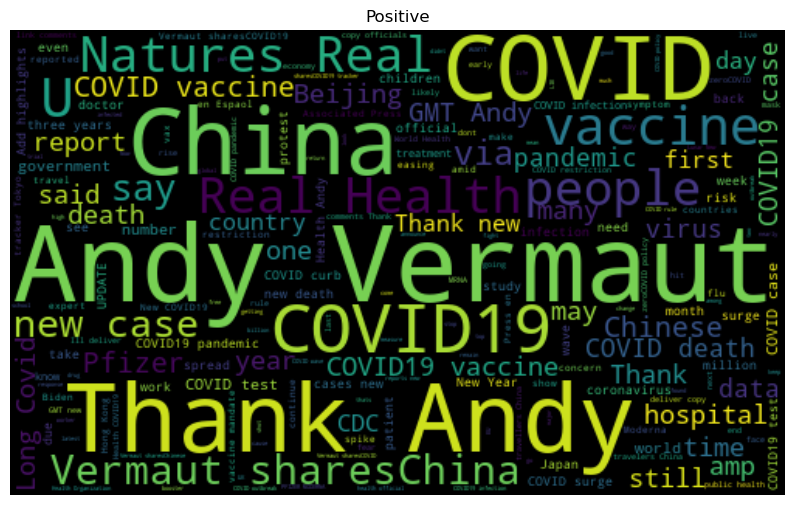

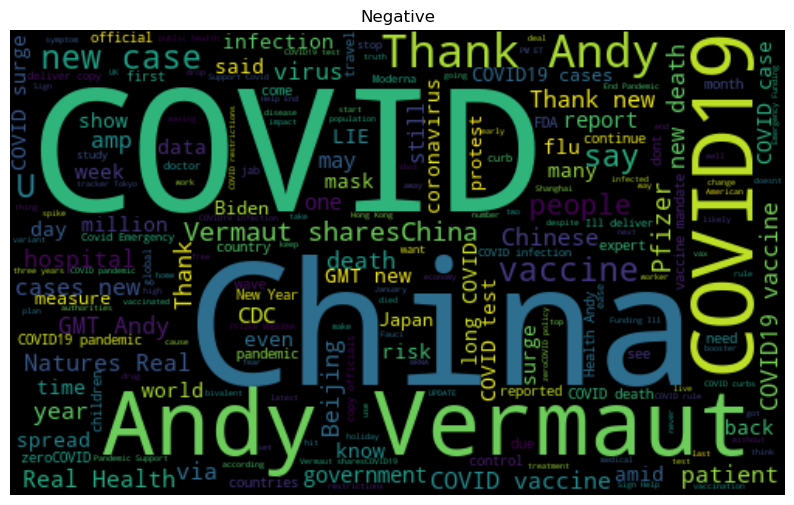

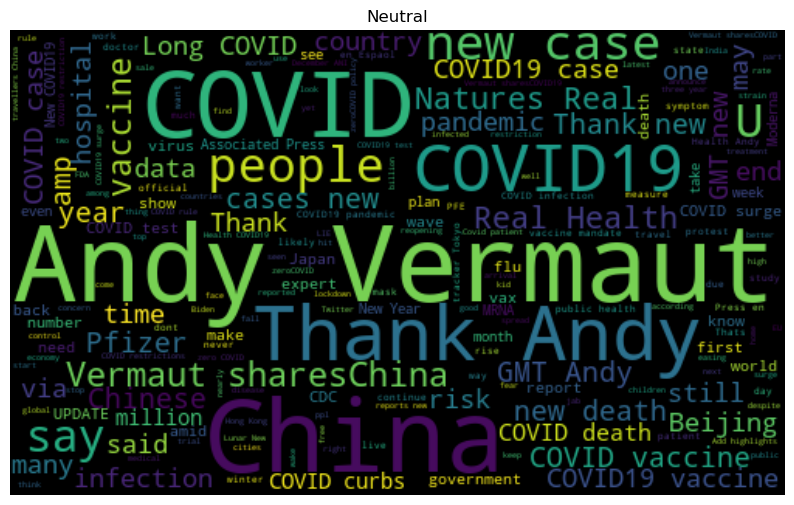

<Figure size 1000x800 with 0 Axes>

In [29]:
plt.figure(figsize = (10,8))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(positive_tweet, 'Positive')
cloud_of_Words(negative_tweet, 'Negative')
cloud_of_Words(neutral_tweet, 'Neutral')

5609
5206
2670


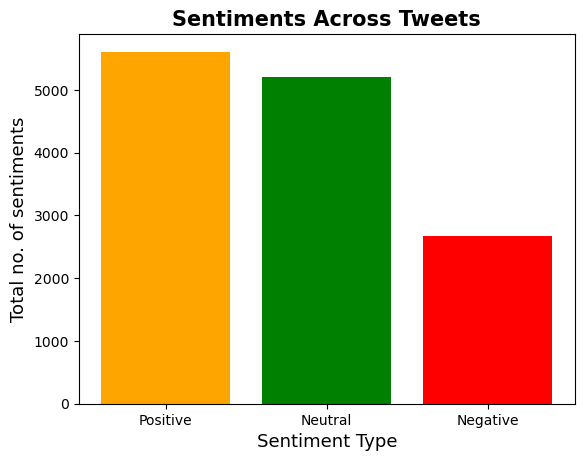

In [30]:
plt.title('Sentiments Across Tweets',fontsize = 15, fontweight = 'bold')

pos_total = data[data['Textblob'] == 'Positive']['Textblob'].count()
neu_total = data[data['Textblob'] == 'Neutral']['Textblob'].count()
neg_total = data[data['Textblob'] == 'Negative']['Textblob'].count()
print(pos_total)
print(neu_total)
print(neg_total)

sentiment_type = ['Positive','Neutral','Negative']
sentiment_total = [pos_total, neu_total, neg_total]

plt.bar(sentiment_type, sentiment_total, color = ['orange', 'green', 'red'])
plt.ylabel('Total no. of sentiments',fontsize=13)
plt.xlabel('Sentiment Type',fontsize=13)
plt.show()

### <font color=#FF0000>**Sentiment Analysis (Using Sentiment Intensity Analyzer)**</font> <br>

A class in the nltk (Natural Language Toolkit) library of Python that is used for sentiment analysis of text data. Specifically, it is a rule-based sentiment analysis tool that uses a lexicon of words and their associated sentiment scores to compute the overall sentiment of a piece of text.

The SentimentIntensityAnalyzer() class has a polarity_scores() method that takes a string of text as input and returns a dictionary containing the sentiment scores for that text. 

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = data.text.apply(ps)
sentiment_scores

0        {'neg': 0.159, 'neu': 0.733, 'pos': 0.108, 'co...
1        {'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp...
2        {'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'comp...
3        {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...
4        {'neg': 0.182, 'neu': 0.725, 'pos': 0.093, 'co...
                               ...                        
20555    {'neg': 0.11, 'neu': 0.731, 'pos': 0.16, 'comp...
20556    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
20557    {'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'comp...
20558    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
20559    {'neg': 0.449, 'neu': 0.551, 'pos': 0.0, 'comp...
Name: text, Length: 17020, dtype: object

In [33]:
sentiment_df = pd.DataFrame(data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.159  0.733  0.108   -0.0516
1  0.167  0.833  0.000   -0.2960
2  0.000  0.898  0.102    0.3612
3  0.000  0.887  0.113    0.5574
4  0.182  0.725  0.093   -0.7430

We can see that there is neg for negative sentiment, neu for neutral sentiment, pos for positive sentiment, and compound as the average rate of the sentiment. We will focused on the compound.

For negative sentiment, the compound score will be closer to -1, and the opposite goes for the positive sentiment, which will be closer to 1. Neutral sentiment will be a 0.

For our analysis, we will create another column called label, where we will be labelling the scores based on the compound polarity value

In [34]:
labelize = lambda x : 'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['Vader'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

neg    neu    pos  compound     Vader
0  0.159  0.733  0.108   -0.0516  negative
1  0.167  0.833  0.000   -0.2960  negative
2  0.000  0.898  0.102    0.3612  positive
3  0.000  0.887  0.113    0.5574  positive
4  0.182  0.725  0.093   -0.7430  negative

In [35]:
filtered_label = data.join(sentiment_df.Vader)
filtered_label.head()

datetime             tweet_id  \
0  2023-02-27 23:27:46+00:00  1630349000141426688   
1  2023-02-27 22:25:54+00:00  1630333430125973505   
2  2023-02-27 22:12:20+00:00  1630330016902029313   
3  2023-02-27 20:36:33+00:00  1630305909154131968   
4  2023-02-27 20:29:33+00:00  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  \
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
1             ['AndyVermautLovesReutersPressAgency']   
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
3                                                NaN   
4                                                NaN   

                                          clean_data  \
0  Andy Vermaut sharesDOE finds COVID19 pandemic ...   
1        No consensus COVID started says White House   
2  Andy Vermaut sharesABC News Rachel Scott press...   
3  Andy Vermaut sharesModerna Make Milestone Paym...   
4  Andy Vermaut sharesPfizer Talks Buy Cancer Dru...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 1.0, 'sentim...  0.000000      1.000000   
1  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
2  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
3  {'polarity': 0.028571428571428567, 'subjectivi...  0.028571      0.392857   
4  {'polarity': 0.16666666666666666, 'subjectivit...  0.166667      0.633333   

   Textblob     Vader  
0   Neutral  negative  
1   Neutral  negative  
2   Neutral  positive  
3  Positive  positive  
4  Positive  negative

In [36]:
counts_label = pd.DataFrame(filtered_label.Vader.value_counts().reset_index())
counts_label

index  Vader
0  negative   5236
1  positive   4507
2   neutral   3742

<AxesSubplot:xlabel='index', ylabel='Vader'>

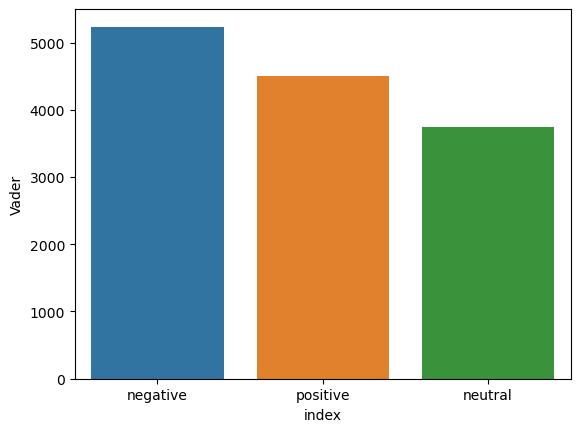

In [37]:
import seaborn as sns
sns.barplot(data=counts_label, x='index', y='Vader')

In [38]:
filtered_label['datetime'] = pd.to_datetime(filtered_label.datetime).dt.date
filtered_label['datetime']

0        2023-02-27
1        2023-02-27
2        2023-02-27
3        2023-02-27
4        2023-02-27
            ...    
20555    2022-12-01
20556    2022-12-01
20557    2022-12-01
20558    2022-12-01
20559    2022-12-01
Name: datetime, Length: 17020, dtype: object

In [39]:
filtered_label.head()

datetime             tweet_id  \
0  2023-02-27  1630349000141426688   
1  2023-02-27  1630333430125973505   
2  2023-02-27  1630330016902029313   
3  2023-02-27  1630305909154131968   
4  2023-02-27  1630304151543349251   

                                                text     username  \
0  Andy Vermaut shares:DOE finds COVID-19 pandemi...  AndyVermaut   
1  'No consensus' on how COVID started, says Whit...  AndyVermaut   
2  Andy Vermaut shares:ABC News’ Rachel Scott pre...  AndyVermaut   
3  Andy Vermaut shares:Moderna to Make Milestone ...  AndyVermaut   
4  Andy Vermaut shares:Pfizer in Talks to Buy Can...  AndyVermaut   

                                                 url      user_location  \
0  https://twitter.com/AndyVermaut/status/1630349...  Diksmuide, België   
1  https://twitter.com/AndyVermaut/status/1630333...  Diksmuide, België   
2  https://twitter.com/AndyVermaut/status/1630330...  Diksmuide, België   
3  https://twitter.com/AndyVermaut/status/1630305...  Diksmuide, België   
4  https://twitter.com/AndyVermaut/status/1630304...  Diksmuide, België   

   like_count  retweet_count  follower_count  reply_count  verified  \
0           0              0           31261            0     False   
1           0              0           31261            0     False   
2           0              0           31261            0     False   
3           0              0           31261            0     False   
4           0              0           31261            0     False   

                                            hashtags  \
0  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
1             ['AndyVermautLovesReutersPressAgency']   
2  ['AndyVermautFromBelgiumLovesABCnews', 'ThankY...   
3                                                NaN   
4                                                NaN   

                                          clean_data  \
0  Andy Vermaut sharesDOE finds COVID19 pandemic ...   
1        No consensus COVID started says White House   
2  Andy Vermaut sharesABC News Rachel Scott press...   
3  Andy Vermaut sharesModerna Make Milestone Paym...   
4  Andy Vermaut sharesPfizer Talks Buy Cancer Dru...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 1.0, 'sentim...  0.000000      1.000000   
1  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
2  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  0.000000      0.000000   
3  {'polarity': 0.028571428571428567, 'subjectivi...  0.028571      0.392857   
4  {'polarity': 0.16666666666666666, 'subjectivit...  0.166667      0.633333   

   Textblob     Vader  
0   Neutral  negative  
1   Neutral  negative  
2   Neutral  positive  
3  Positive  positive  
4  Positive  negative

In [40]:
data_vader = filtered_label[['username', 'datetime', 'Vader']].groupby(['datetime', 'Vader']).count().reset_index()
data_vader.columns = ['date', 'Vader', 'counts']
data_vader.head()

date     Vader  counts
0  2022-12-01  negative      82
1  2022-12-01   neutral      66
2  2022-12-01  positive      61
3  2022-12-02  negative      78
4  2022-12-02   neutral      71

In [41]:
px.line(data_vader, x='date', y='counts', color='Vader', title='COVID-19 Vaccines Sentiment Analysis (Vader)')

In [42]:
data_Textblob = filtered_label[['username', 'datetime', 'Textblob']].groupby(['datetime', 'Textblob']).count().reset_index()
data_Textblob.columns = ['date', 'Textblob', 'counts']
data_Textblob.head()

date  Textblob  counts
0  2022-12-01  Negative      36
1  2022-12-01   Neutral      75
2  2022-12-01  Positive      98
3  2022-12-02  Negative      37
4  2022-12-02   Neutral      92

In [43]:
px.line(data_Textblob, x='date', y='counts', color='Textblob', title='COVID-19 Vaccines Sentiment Analysis (Textblob)')

## Conclusion